In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_file_path = '/content/drive/MyDrive/Copy of vqa_coco_dataset.zip'
import zipfile
import os

# Tạo thư mục đích để giải nén
output_dir = '/content/extracted_files'
os.makedirs(output_dir, exist_ok=True)

# Giải nén file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Files extracted to: {output_dir}")


Files extracted to: /content/extracted_files


## __1. Import libraries and set random seed__

In [3]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.13
    Uninstalling timm-1.0.13:
      Successfully uninstalled timm-1.0.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 

In [4]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __2. Read dataset__

In [6]:
train_data = []
train_set_path = '/content/extracted_files/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [7]:
val_data = []
val_set_path = '/content/extracted_files/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [8]:
test_data = []
test_set_path = '/content/extracted_files/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

## __3. Data Preprocessing__

In [9]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [10]:
len(vocab)

1678

In [11]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [12]:
example_question = "Is this a picture of an apple?"
max_seq_len = 20

tokenize(example_question, max_seq_len)

[6, 5, 7, 16, 21, 75, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
def detokenize(sequence):
    idx_to_token = vocab.get_itos()

    tokens = [idx_to_token[idx] for idx in sequence if idx_to_token[idx] not in ['<pad>', '<sos>', '<eos>', '<unk>']]

    return " ".join(tokens)

In [14]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'yes', 1: 'no'}


## __4. Create Pytorch dataset__

In [23]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        max_seq_len=20,
        transform=None,
        img_dir='/content/extracted_files/val2014-resised/'
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.img_dir = img_dir
        self.label2idx = label2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = label2idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [24]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [25]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform['train']
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform['val']
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=data_transform['val']
)

In [26]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## __5. Create VQA model__

In [27]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name,
        embeddding_dim,
        n_layers=2,
        hidden_size=256,
        drop_p=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        for param in self.image_encoder.parameters():
            param.requires_grad = True

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm1 = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=drop_p
        )

        self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
        self.dropout = nn.Dropout(drop_p)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm1(text_emb)

        lstm_out = lstm_out[:, -1, :]

        combined = torch.cat((img_features, lstm_out), dim=1)
        x = self.fc1(combined)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [28]:
n_classes = len(classes)
img_model_name = 'resnet18'
hidden_size = 256
n_layers = 2
embeddding_dim = 128
drop_p = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

In [29]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([256, 2])


## __6. Training__

In [30]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [31]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [34]:
lr = 1e-3
epochs = 10

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [35]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.6922	Val loss: 0.6931	Val Acc: 0.5005122950819673
EPOCH 2:	Train loss: 0.6930	Val loss: 0.6910	Val Acc: 0.5358606557377049
EPOCH 3:	Train loss: 0.6914	Val loss: 0.6924	Val Acc: 0.53125
EPOCH 4:	Train loss: 0.6916	Val loss: 0.6905	Val Acc: 0.5297131147540983
EPOCH 5:	Train loss: 0.6919	Val loss: 0.6962	Val Acc: 0.4636270491803279
EPOCH 6:	Train loss: 0.6913	Val loss: 0.6925	Val Acc: 0.5276639344262295
EPOCH 7:	Train loss: 0.6908	Val loss: 0.6901	Val Acc: 0.5353483606557377
EPOCH 8:	Train loss: 0.6912	Val loss: 0.6896	Val Acc: 0.5271516393442623
EPOCH 9:	Train loss: 0.6890	Val loss: 0.6919	Val Acc: 0.5322745901639344
EPOCH 10:	Train loss: 0.6873	Val loss: 0.6919	Val Acc: 0.5399590163934426


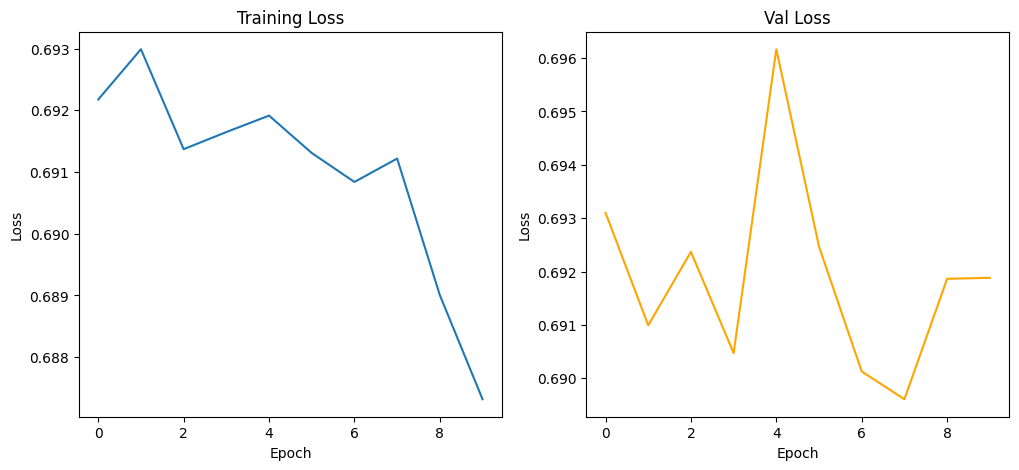

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## __7. Evaluation__

In [37]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5399590163934426
Test accuracy:  0.5435212660731948


## __8. Inference__

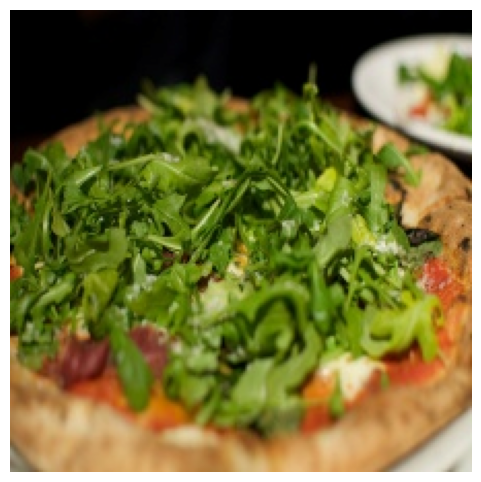

Question: Is this a pizza ?
Groundtruth: yes
Predicted: yes


In [40]:
idx = 22
img_name = test_data[idx]['image_path']
img_path = os.path.join('/content/extracted_files/val2014-resised', img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

max_seq_len = 20
question_processed = torch.tensor(tokenize(question, max_seq_len)).unsqueeze(0).to(device)

img = Image.open(img_path).convert("RGB")
img_processed = data_transform['val'](img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])
image_vis = reverse_transform(img_processed.squeeze(0).cpu())

origin_quest = detokenize(question_processed.squeeze(0).cpu().tolist())

plt.figure(figsize=(6, 6))
plt.imshow(image_vis)
plt.axis('off')
plt.show()

print(f'Question: {origin_quest}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')